In [1]:
from SFcalculator.Fmodel import SFcalculator

2022-10-27 17:22:09.259997: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-27 17:22:11.309423: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-27 17:22:16.824143: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/helmod/apps/centos7/Core/cudnn/8.2.2.26_cuda11.4-fasrc01/lib64:/n/helmod/apps/centos7/Core/cuda/11.4.2-fasrc01/cuda/extras/CUPTI/lib64:/n/helmod/apps/centos7/Core/cuda/11.4.2-fasrc01/cuda/lib64:/n/helm

In [21]:
import tensorflow as tf

In [2]:
import reciprocalspaceship as rs
import numpy as np

In [3]:
sfcalculator = SFcalculator("../data/4xof.pdb", mtzfile_dir="../data/4xof.mtz", set_experiment=True)

2022-10-27 17:22:56.416625: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-27 17:22:59.324936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30975 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:2f:00.0, compute capability: 7.0


In [4]:
sfcalculator.inspect_data()

Solvent Percentage: 11.0
Grid size: [80, 120, 144]


In [5]:
Fprotein = sfcalculator.Calc_Fprotein(Print=True)

In [6]:
Fsolvent = sfcalculator.Calc_Fsolvent(Print=True, dmin_mask=6.0, dmin_nonzero=3.0)

In [7]:
Fprotein_arr = Fprotein.numpy()
Fsolvent_arr = Fsolvent.numpy()

### Compare with Phenix

In [8]:
Fcalc = rs.read_mtz('../data/4xof_vanilla.mtz')

In [9]:
Fmodel=rs.read_mtz('../data/4xof_ksol1.mtz')

In [10]:
(Fmodel.get_hkls() == Fcalc.get_hkls()).all()

True

In [11]:
calc_mag = Fcalc['FMODEL'].to_numpy()
calc_ph = np.deg2rad(Fcalc['PHIFMODEL'].to_numpy())
Fcalc_complex = np.array([complex(mag*np.cos(ph), mag*np.sin(ph)) 
                            for mag, ph in zip(calc_mag,calc_ph)])

In [12]:
model_mag = Fmodel['FMODEL'].to_numpy()
model_ph = np.deg2rad(Fmodel['PHIFMODEL'].to_numpy())
Fmodel_complex = np.array([complex(mag*np.cos(ph), mag*np.sin(ph)) 
                            for mag, ph in zip(model_mag,model_ph)])

In [13]:
Fmask_complex = Fmodel_complex - Fcalc_complex

In [14]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr,spearmanr

def linear_corr(a,b):
    reg = LinearRegression().fit(a.reshape(-1,1),b.reshape(-1,1))
    print("Linear Fit Coeff:", reg.coef_)
    print("R square:", reg.score(a.reshape(-1,1),b.reshape(-1,1)))
    print("Pearsonr:", pearsonr(a,b))
    print("Spearmanr:", spearmanr(a,b))
    
def comp_plot(mag_a, mag_b, ph_a, ph_b, name_a,name_b, dpi=None):
    fig,ax=plt.subplots(1,2,figsize=[10,4], dpi=dpi)
    ax[0].plot(mag_a, mag_b, '.', alpha=0.4)
    ax[0].set_xlabel(name_a)
    ax[0].set_ylabel(name_b)
    ax[0].set_title("Magnitude")

    ax[1].plot(ph_a, ph_b, '.', alpha=0.4)
    ax[1].set_xlabel(name_a)
    ax[1].set_ylabel(name_b)
    ax[1].set_title("Phase")
    plt.show()
    
def comp_plot_complex(a,b,name_a,name_b, dpi=None):
    fig,ax=plt.subplots(1,3,figsize=[15,4], dpi=dpi)
    ax[0].plot(np.real(a), np.real(b), '.', alpha=0.4)
    ax[0].set_xlabel(name_a)
    ax[0].set_ylabel(name_b)
    ax[0].set_title("Real Part")

    ax[1].plot(np.imag(a), np.imag(b), '.', alpha=0.4)
    ax[1].set_xlabel(name_a)
    ax[1].set_ylabel(name_b)
    ax[1].set_title("Imaginary Part")

    ax[2].plot(np.abs(a), np.abs(b), '.', alpha=0.4)
    ax[2].set_xlabel(name_a)
    ax[2].set_ylabel(name_b)
    ax[2].set_title("Magnitude")
    plt.show()

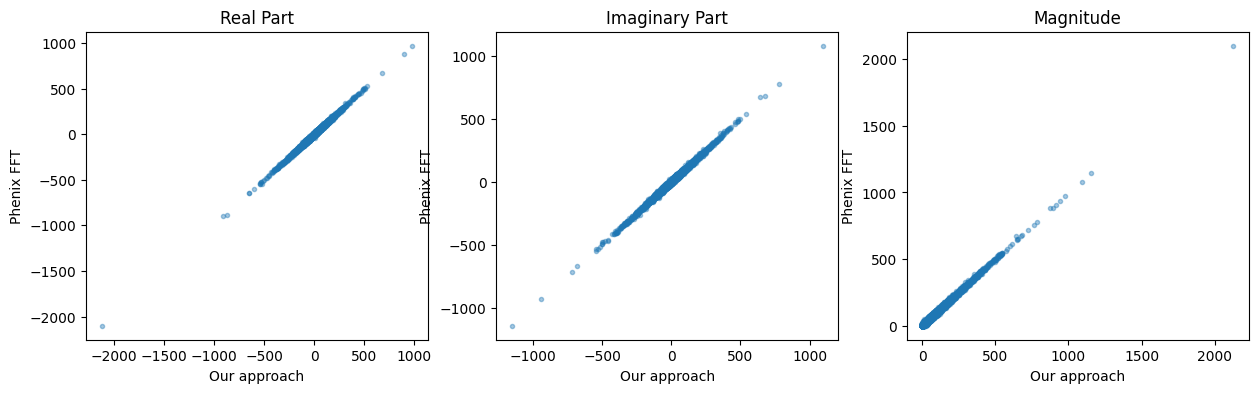

In [15]:
# Protein Part
comp_plot_complex(Fprotein_arr, Fcalc_complex, "Our approach", "Phenix FFT", dpi=100)

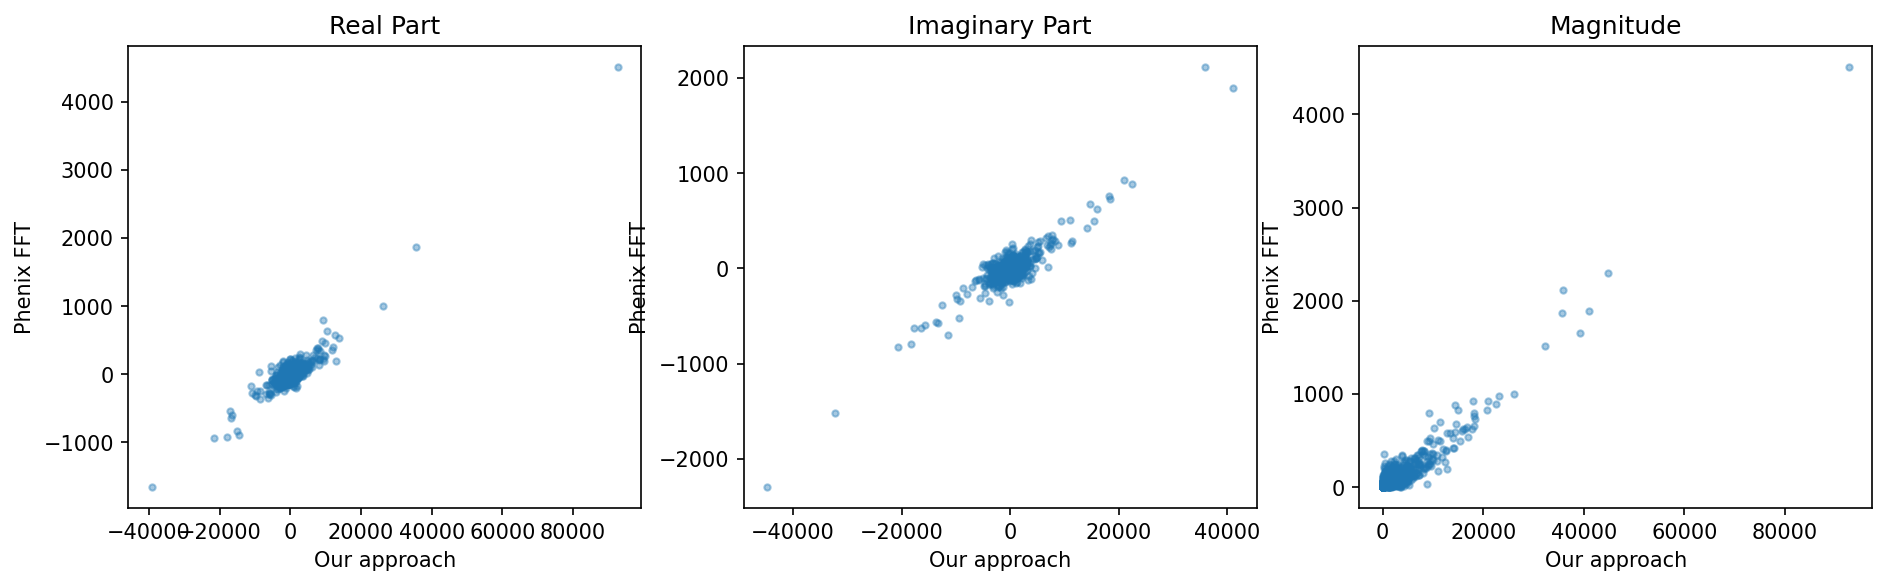

In [16]:
comp_plot_complex(Fsolvent, Fmask_complex, "Our approach", "Phenix FFT", dpi=150)

### Gradient Descent for the scales

In [24]:
from SFcalculator.utils import r_factor
import time

In [25]:
sfcalculator.Calc_Fprotein()
sfcalculator.Calc_Fsolvent(dmin_mask=6, dmin_nonzero=3.0)

In [26]:
def scale_train(optimizer, sfcalculator, n_steps=1000, loss_track=[], verbose=True):
    @tf.function
    def scale_steptrain(optimizer, sfcalculator):
        with tf.GradientTape() as tape:
            Fmodel = sfcalculator.Calc_Ftotal(kall=kall, kaniso=kaniso, ksol=ksol, bsol=bsol)
            Fmodel_mag = tf.abs(Fmodel)
            loss = tf.reduce_sum((sfcalculator.Fo - Fmodel_mag)**2)
            r_work, r_free = r_factor(sfcalculator.Fo, Fmodel_mag, sfcalculator.rwork_id, sfcalculator.rfree_id)
        grads = tape.gradient(loss, [kall, kaniso, ksol, bsol])
        optimizer.apply_gradients(zip(grads, [kall, kaniso, ksol, bsol]))
        return loss, r_work, r_free
    
    for k in range(n_steps):
        start_time = time.time()

        temp = scale_steptrain(optimizer, sfcalculator)
        loss_track.append([i.numpy() for i in temp])

        time_this_round = round(time.time() - start_time, 3)
        str_ = "Time: " + str(time_this_round)

        if verbose:
            print("Scale", *loss_track[-1], str_, flush=True)
    
    return loss_track

In [27]:
kall = tf.Variable(0.5)
kaniso = tf.Variable(tf.random.normal([6], mean=0.01, stddev=0.01))
ksol = tf.Variable(0.1)
bsol = tf.Variable(.0)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [28]:
loss_track = scale_train(optimizer, sfcalculator, n_steps=2000, loss_track=[], verbose=True)

Scale 67306050.0 0.5566142 0.59748477 Time: 1.261
Scale 56663110.0 0.5345202 0.56679463 Time: 0.005
Scale 48312480.0 0.5104415 0.5356019 Time: 0.003
Scale 41526096.0 0.48065323 0.5004472 Time: 0.004
Scale 35881116.0 0.44674355 0.46243274 Time: 0.003
Scale 31267322.0 0.41183445 0.42454538 Time: 0.003
Scale 27405508.0 0.3801506 0.39183924 Time: 0.003
Scale 24241970.0 0.35594073 0.36559388 Time: 0.003
Scale 21861032.0 0.34282145 0.34834197 Time: 0.003
Scale 20102250.0 0.34157535 0.35265166 Time: 0.004
Scale 18851950.0 0.35158542 0.3598891 Time: 0.004
Scale 18607214.0 0.36961782 0.38372028 Time: 0.003
Scale 19147436.0 0.39027065 0.40780565 Time: 0.003
Scale 19973508.0 0.40723547 0.42729926 Time: 0.003
Scale 20564684.0 0.4163767 0.43819904 Time: 0.003
Scale 20631268.0 0.41657093 0.43926722 Time: 0.003
Scale 20090422.0 0.40855518 0.43143126 Time: 0.003
Scale 19035054.0 0.3944265 0.41693163 Time: 0.003
Scale 17656572.0 0.37657532 0.3983214 Time: 0.003
Scale 16178850.0 0.35741368 0.37790683 Ti